# Alexnet

AlexNet consists of 5 Convolutional Layers and 3 Fully Connected Layers. Multiple Convolutional Kernels (a.k.a filters) extract interesting features in an image

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
tf.random.set_seed(101)

In [2]:
# Setting Some Pre-Requisites
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000         # We will be training 80,000 samples from each label

In [3]:
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [4]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

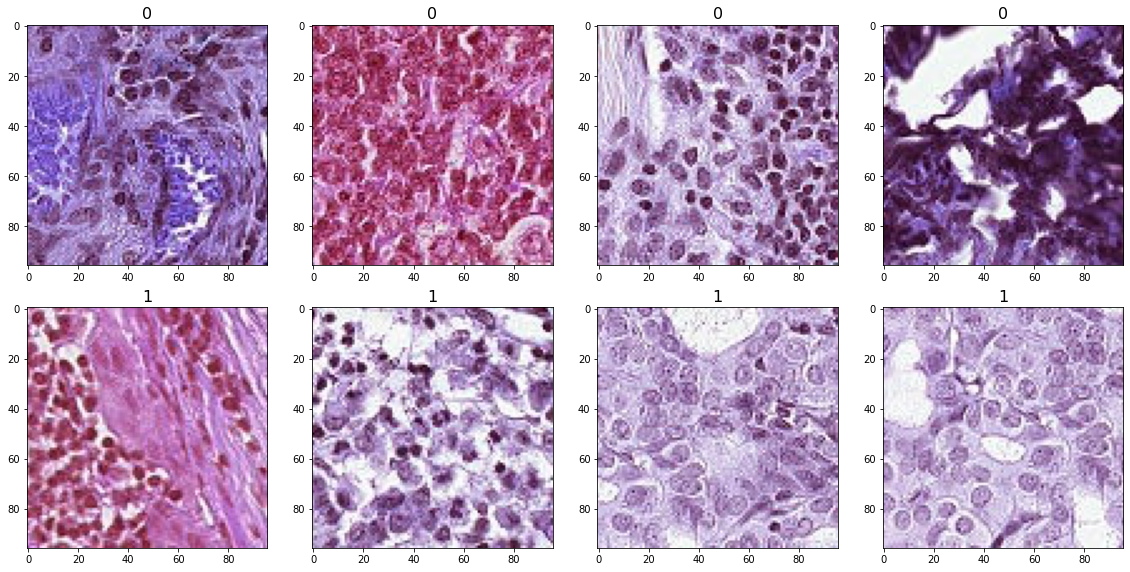

In [5]:
IMAGE_PATH = '../input/histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

In [6]:
# train_data['label'].value_counts()

In [7]:
df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [8]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [9]:
from pathlib import Path

dir_path = Path('./base_dir')

try:
    dir_path.rmdir()
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

Error: base_dir : No such file or directory


In [10]:
# Create a new directory so that we will be using the ImageDataGenerator
base_dir='base_dir'
os.mkdir(base_dir)

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')

os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')

os.mkdir(val_dir)

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
#os.rmdir(no_tumor_tissue)
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
#os.rmdir(has_tumor_tissue)
os.mkdir(has_tumor_tissue)

In [11]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

In [12]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [13]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])


countt=1
# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
#     print(countt)
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    countt=countt+1


# Transfer the val images
count=1
for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
#     print(count)
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    count=count+1

In [14]:

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

72000
72000
8000
8000


In [15]:
import numpy as np

In [16]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [17]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [18]:
from keras.layers.normalization import BatchNormalization

In [19]:
# Initialize the model.
model = Sequential()
          
# 1st Convolutional Layer
model.add(Conv2D(filters = 96, input_shape = (96,96,3), kernel_size = (11,11), strides = (4,4), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 4th Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 5th Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))
# Dropout
model.add(Dropout(0.5))

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096, input_shape = (96*96*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.25))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))

# Get the model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 22, 22, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 22, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 256)       1

In [20]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [21]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [22]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


14400/14400 [==============================] - 214s 15ms/step - loss: 0.6635 - accuracy: 0.6827 - val_loss: 0.5257 - val_accuracy: 0.7612
Epoch 2/10
14400/14400 [==============================] - 187s 13ms/step - loss: 0.4941 - accuracy: 0.7708 - val_loss: 0.5989 - val_accuracy: 0.7802
Epoch 3/10
14400/14400 [==============================] - 181s 13ms/step - loss: 0.4509 - accuracy: 0.7969 - val_loss: 0.9608 - val_accuracy: 0.6378
Epoch 4/10
14400/14400 [==============================] - 182s 13ms/step - loss: 0.4331 - accuracy: 0.8061 - val_loss: 0.5653 - val_accuracy: 0.7345
Epoch 5/10
14400/14400 [==============================] - 186s 13ms/step - loss: 0.4152 - accuracy: 0.8175 - val_loss: 0.5973 - val_accuracy: 0.6814
Epoch 6/10
14400/14400 [==============================] - 195s 14ms/step - loss: 0.4099 - accuracy: 0.8215 - val_loss: 0.8462 - val_accuracy: 0.6104
Epoch 7/10
14400/14400 [==============================] - 184s 13ms/step - loss: 0.4024 - accuracy: 0.8253 - val_loss

In [23]:

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.4260745942592621
val_acc: 0.8379374742507935


In [24]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [25]:
#Save the last model  
model.save('model.h5')

<Figure size 432x288 with 0 Axes>

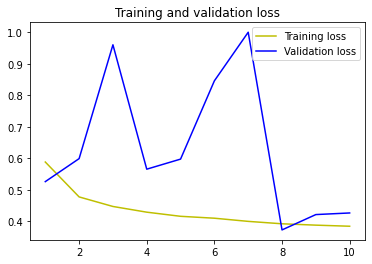

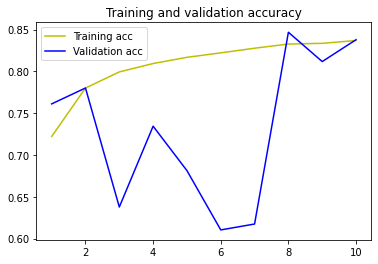

<Figure size 432x288 with 0 Axes>

In [37]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss,'y' ,label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc,'y',label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [27]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


16000/16000 [==============================] - 41s 3ms/step


In [28]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

In [29]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9166556796875

## Accuracy plot

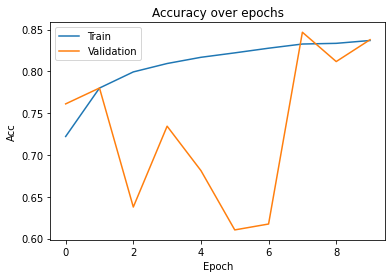

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

## Loss vs epochs plot

<Figure size 432x288 with 0 Axes>

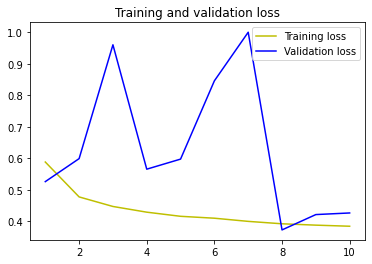

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(epochs, loss,'y' ,label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

In [ ]:
pred=model.predict_generator(test_generator,verbose=1)

1375/1375 [==============================] - 3419s 2s/step - loss: 0.5451 - accuracy:0.7659